Ce notebook est une réalisation du kaggle suivant : https://www.kaggle.com/competitions/home-credit-default-risk

# **COMPRÉHENSION DE LA PROBLÉMATIQUE MÉTIER**

Objectif : Mettre en place un modèle de "scoring crédit" qui calcule la probabilité qu'un client rembourse ou non un crédit accordé.

* Compréhension de la problématique métier
* Description du jeu de données
* Transformation du jeu de données (nettoyage et feature engineering)
* Comparaison et synthèse des résultats pour les modèles utilisés
* Interprétabilité du modèle
* Conclusion

Nous utiliserons un kernel kaggle pour réaliser notre étude. Voici un lien : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook

# **IMPORTATION DES BIBLIOTHÈQUES PYTHON**

In [4]:
# numpy et pandas pour la manipulation de données
import pandas as pd
import numpy as np

# counter and time
from collections import Counter
import time

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# matplotlib et saeborn pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# **IMPORTATION DU JEU DE DONNÉES**

In [6]:
# Chargement des csv 
app_train = pd.read_csv("application_train.csv", sep=',', low_memory=False)
app_test = pd.read_csv("application_test.csv", sep=',', low_memory=False)

In [7]:
# Training data
print() # Saut de ligne
print("Dimension des données d'entrainement:", app_train.shape)
print()
app_train.head()


Dimension des données d'entrainement: (307511, 122)



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Notre jeu de données d'entrainement inclut une variable catégorielle cible TARGET. 
Nous allons pouvoir appliquer différents algorithmes supervisés de classification pour prédire TARGET.

In [ ]:
# Testing data
print() # Saut de ligne
print("Dimension des données tests:", app_test.shape)
print()
app_test.head()


Dimension des données tests: (48744, 121)



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Dans le jeu de données test nous n'avons pas de colonne TARGET car nous souhaitons la prédire grâce à notre modèle de ML

# **ANALYSE EXPLORATOIRE**

L'analyse exploratoire va nous permettre d'analyser d'un point de vue global nos jeu de données. Dans notre cas, la variable TARGET est centrale et essentielle à notre étude car l'objectif est de pouvoir la prédire sur un jeu de données non labellisé.

## **Colonne TARGET**

TARGET est la variable que nous souhaitons prédire : soit 0 pour un prêt remboursé à temps ou 1 pour des difficultés de remboursement.

In [ ]:
# Proportion de prêts remboursés ou pas
target_proportion = app_train['TARGET'].value_counts()
df_target_proportion = pd.DataFrame(target_proportion)
df_target_proportion = df_target_proportion.rename_axis('LABELS').reset_index()

#df_target_proportion

# Pie Chart de la colonne TARGET
fig = px.pie(df_target_proportion, values='TARGET', 
             names='LABELS', 
             title='PROPORTION DE PRÊTS REMBOURSÉS')
fig.show()

Grâce à ce graphique, on remarque que la grande majorité des prêts sont remboursés à temps. 
Cependant, on remarque que la modalité 0 (prêt remboursé) a beaucoup plus de valeurs que 1. Ainsi, nous avons ici un problème de "Class Imbalance" qui peut impacter notre modèle prédictif.

La classe REMBOURSE PAS = 1 sera la classe positive
La classe REMBOURSE = 0 sera la classe négative

## **Étude des valeurs manquantes**

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Statistique sur les valeurs manquantes
missing_values = missing_values_table(app_train)
missing_values.head()

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4


In [ ]:
# Imputation NAN values with median
column_medians_train = app_train.median()
column_medians_test = app_test.median()

app_train = app_train.fillna(column_medians_train)
app_test = app_test.fillna(column_medians_test)

<ipython-input-10-0b6fa1362fd6>:2: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

<ipython-input-10-0b6fa1362fd6>:3: FutureWarning:

The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



## **Type des colonnes**

In [ ]:
# Nombre de type par colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Le type "object" représente les valeurs catégorielles. Nous allons entrer plus en détails pour ce type de colonne.

In [ ]:
# Nombre de valeurs (classes) uniques dans chaque object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La majorité des variables catégorielles ont un faible nombre de valeur unique.

## **Transformer les variables catégorielles**

Nous disposons de deux méthodes pour convertir les variables catégorielles en variables numériques : 
  Label encoding
  One hot Encoding

Pour les variables avec 2 valeurs uniques on utilisera le Label encoding. Pour les variables avec 3 ou plus valeurs uniques, on utilisera One hot encoding

### **Label encoding**

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


### **One hot encoding**

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


On remarque que le One hot encoding a créé un déséquilibre sur le nombre de colonnes entre training et testing set. Nous allons ici aligner le nombre de colonnes des deux dataset.

In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Nous disposons maintenant d'un training et testing set qui ont le même nombre de colonnes ( en excluant la colonne TARGET).

# **RETOUR À L'ANALYSE EXPLORATOIRE**

In [ ]:
app_train.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307511.000000,3.075110e+05,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,278180.518577,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.487841,5.383163e+05,0.020868,...,0.030090,0.007466,0.005785,0.005284,0.214757,0.210773,0.017437,0.518446,0.007570,0.080729
std,102790.175348,0.293509,0.473746,0.460968,0.722121,2.371231e+05,4.024908e+05,14493.461065,3.692890e+05,0.013831,...,0.170835,0.086085,0.075840,0.072501,0.410654,0.407858,0.130892,0.499660,0.086679,0.272419
min,100002.000000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,367142.500000,0.000000,1.000000,1.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,456255.000000,1.000000,1.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## **Corrélations**

La variable TARGET est centrale pour notre étude car nous allons essayer par la suite de la prédire en fonction des autres variables du jeu de données. 
Ainsi, il est intéressant d'étudier la corrélation entre la variable TARGET et les autres variables du dataset pour en déduire les plus fortes corrélations

In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Pour les corrélations positives, la variable DAYS_BIRTH est la plus corrélée à TARGET.


### **Variable DAYS_BIRTH**

In [ ]:
# Étude détaillée de la variable DAYS_BIRTH
app_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

On remarque des valeurs négatives pour l'age des clients en jours. Nous allons dans un premier temps repasser en positives et convertir en années.

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
#app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

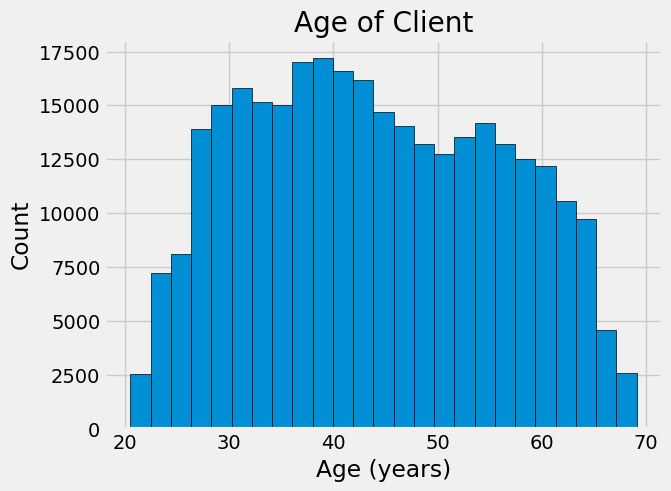

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

La répartition des clients par tranche d'âges semble correct.

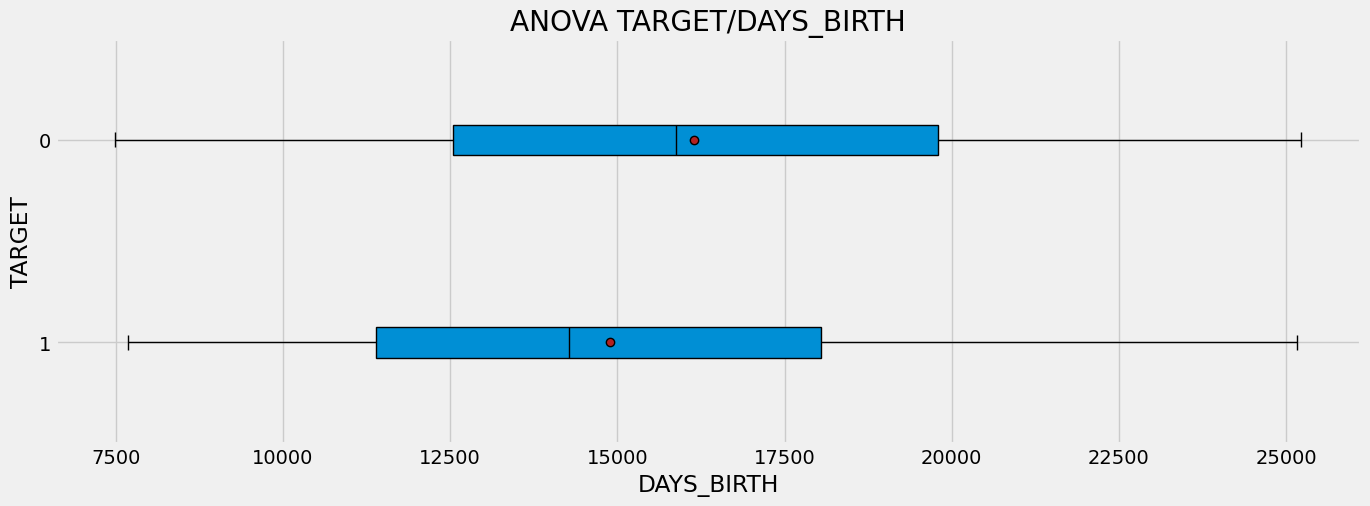

In [ ]:
# Tracé de l'ANOVA entre TARGET et DAYS_BIRTH
modalites = app_train["TARGET"].unique()
modalites
groupes = []
for m in modalites:
    groupes.append(abs(app_train[app_train["TARGET"]==m]["DAYS_BIRTH"]))

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
             'markerfacecolor':'firebrick'}

plt.figure(figsize=(15, 5))
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.title("ANOVA TARGET/DAYS_BIRTH")
plt.xlabel("DAYS_BIRTH")
plt.ylabel("TARGET")

plt.show()

Logiquement, on remarque que plus un emprunteur est agé plus il a de chance de rembourser son prêt car les revenus augmentent au cours de la vie professionnelle.
Il pourra être intéressant pour l'organisme prêteur de demander des garanties suplémentaires pour les clients les plus jeunes (apport plus élevé par exemple).

### **Variables EXT_SOURCE**

Les 3 variables EXT_SOURCE sont les plus corrélées négativement à la variable TARGET.
Nous allons étudier ces variables entre elles.

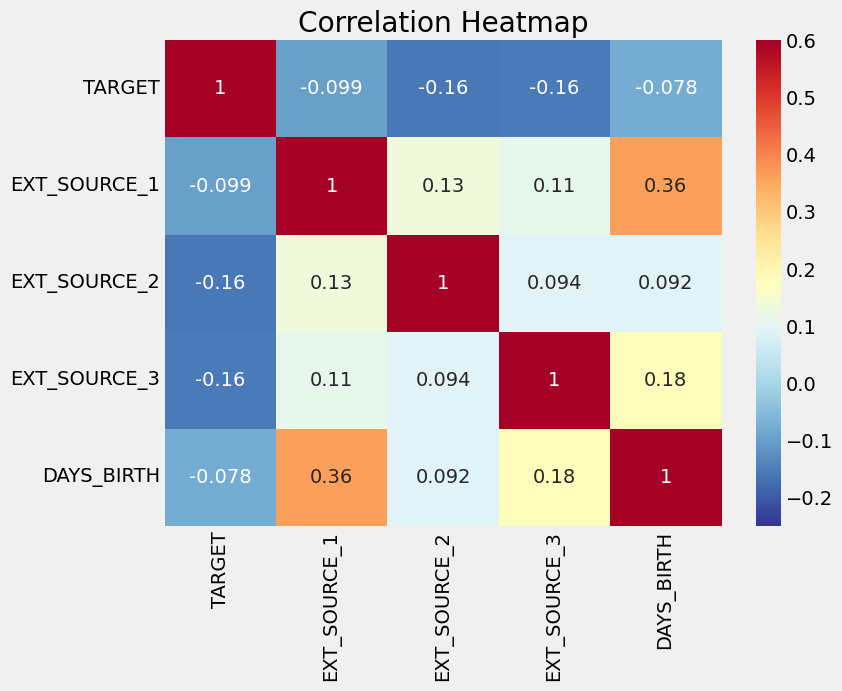

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
# ext_data_corrs

plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, 
            vmin = -0.25, vmax = 0.6, annot = True)
plt.title('Correlation Heatmap');

Les 3 sources externes sont corrélées négativement à TARGET. Ainsi, quand EXT_SOURCE augmentent, les emprunteurs ont plus de chance de rembourser leurs prêts. 
Autre point intéressant, EXT_SOURCE_1 et DAYS_BIRTH sont très corrélées entre elles, ainsi une composante importante de cette variable est liée à l'âge.

# **FEATURE ENGINEERING**

Notre jeu de donées est composé de 239 colonnes. Nous allons créer de nouvelles variables qui auront potentiellement une importance sur la réalisation de notre modèle de prédiction

In [ ]:
# Some simple new features (percentages)
app_train['DAYS_EMPLOYED_PERC'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['INCOME_CREDIT_PERC'] = app_train['AMT_INCOME_TOTAL'] / app_train['AMT_CREDIT']
app_train['INCOME_PER_PERSON'] = app_train['AMT_INCOME_TOTAL'] / app_train['CNT_FAM_MEMBERS']
app_train['ANNUITY_INCOME_PERC'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['PAYMENT_RATE'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']

app_test['DAYS_EMPLOYED_PERC'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']
app_test['INCOME_CREDIT_PERC'] = app_test['AMT_INCOME_TOTAL'] / app_test['AMT_CREDIT']
app_test['INCOME_PER_PERSON'] = app_test['AMT_INCOME_TOTAL'] / app_test['CNT_FAM_MEMBERS']
app_test['ANNUITY_INCOME_PERC'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['PAYMENT_RATE'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']

# **APPLICATION DES MODÈLES ML**

In [ ]:
# Import Libraries
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.pipeline import Pipeline
# Oversample and plot imbalanced dataset with SMOTE
from imblearn.over_sampling import SMOTE

## **Normalisation et imputation du jeu de données**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

# Feature names
#features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan,
                        strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fitting the data to the imputer object
imputer = imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 244)
Testing data shape:  (48744, 244)


In [ ]:
# app_test n'a pas de variable TARGET. Ainsi, nous allons séparer app_train en training set et testing set 
# pour réaliser nos mesures de performance. 
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train, app_train['TARGET'], test_size=0.2, random_state=42)

## **Baseline : Dummy Classifier**

In [ ]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(random_state=42) 
#establishing random_state for reproducibility
clf_dummy.fit(train, train_labels)
pred = clf_dummy.predict(test)

ras = roc_auc_score(train_labels, clf_dummy.predict_proba(train)[:, 1])
print('Mean AUROC: %.3f' % ras)

Mean AUROC: 0.500


Le modèle baseline nous retourne un AUROC = 0.50. Il s'agit bien d'un modèle aléatoire.
Notre objectif sera donc de trouver un modèle avec un meilleur score que la baseline.

## **Logistic Regression**

Nous avons un problème de classification de type binaire (0 = prêt remboursé, majority class, negative class et 1 = prêt non remboursé, minority class, positive class) nous allons dons utiliser des algorithmes de classification dans la suite. Nous avons besoin d'une baseline.

Nous allons tester notre algorithme de régréssion logistique avec deux méthodes de gestion des données déséquilibrées : 
  1 - Cost-Sensitive Learning
  2 - Sampling Learning

### **Cost-Sensitive Learning**

Ce modèle va moins fortement pénaliser la classe majoritaire (0) et plus fortement la classe minoritaire (1) pour les erreurs faites.
https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

In [ ]:
# Define the ML model
logregCS = LogisticRegression(class_weight = 'balanced')

# define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs'],
    'C' : [0.0001, 0.001, 0.01]
}

# define the cross-validation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# define the search procedure
grid = GridSearchCV(logregCS, param_grid, cv=cv, scoring='roc_auc')
# perform the search
grid.fit(X_train, y_train)

# print the best parameters
print('Meilleurs paramètres: ', grid.best_params_)
print('Meilleur estimateur: ', grid.best_estimator_)
print('Meilleurs scores (AUROC): ', grid.best_score_)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning:

Line Search failed

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning:

Line Search failed

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packa

Meilleurs paramètres:  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur estimateur:  LogisticRegression(C=0.01, class_weight='balanced')
Meilleurs scores (AUROC):  0.7421979456248422


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



AUROC:  0.6774130969856536

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56554
           1       0.16      0.67      0.25      4949

    accuracy                           0.68     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.68      0.76     61503

Temps éxecution:  20.476832151412964


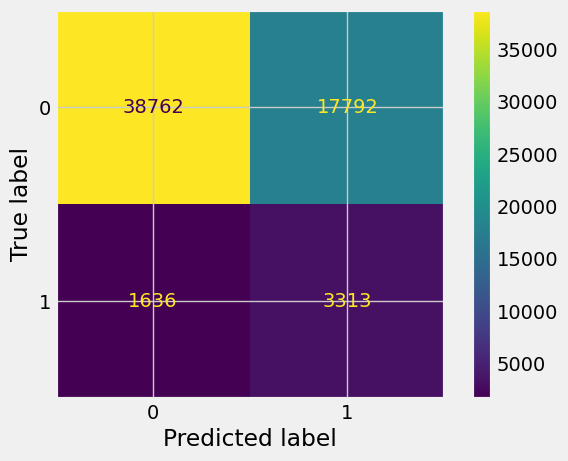

In [ ]:
#best_logregCS = grid.best_estimator_
best_logregCS = LogisticRegression(C=0.01, solver='lbfgs', penalty='l2', class_weight ='balanced')

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
best_logregCS.fit(X_train, y_train)
execution_time_best_logregCS = time.time() - start_time
# Make predictions on the testing data
best_logregCS_pred = best_logregCS.predict(X_test)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, best_logregCS_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_logregCS.classes_)
disp.plot()

# Print results
auroc_best_logregCS = roc_auc_score(y_test, best_logregCS_pred)
print('AUROC: ', auroc_best_logregCS)
print()
print(classification_report(y_test, best_logregCS_pred))
print('Temps éxecution: ', execution_time_best_logregCS)

Dans notre cas on cherche à minimiser le nombre d'emprunteur qui ne vont pas rembourser. C'est-à-dire, avoir un nombre de False Négative le plus faible possible. Ici, on a : FN : 1636.

L'indicateur AUROC nous donne une valeur AUROC de 68 %
L'indicateur de sensibilité nous donne une valeur de 67 % pour la classe 1. A. Ce qui est un très mauvais résultat car 33 % d'emprunteur qui ne pourront pas rembourser se feront attribuer un prêt.


*Area* Under ROC Curve (AUROC): AUROC represents the likelihood of your model distinguishing observations from two classes.
In other words, if you randomly select one observation from each class, what’s the probability that your model will be able to “rank” them correctly?

### **Sampling Methods : SMOTE**

La méthode SMOTE va échantilloner la class minoritaire pour ajouter autant d'observations que dans la classe majoritaire. On se retrouvera donc avec un dataset équilibré 

In [ ]:
# Create the SMOTE object
smote = SMOTE(sampling_strategy='auto', k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [ ]:
# Define the parameter grid to search
param_grid = {
    'penalty': ['l2'],
    'C': [0.0001, 0.001, 0.01],
    'solver': ['newton-cg'],
    'class_weight': ['balanced']
}

# Create a logistic regression model
logreg = LogisticRegression()
# Create the StratifiedKFold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Create the grid search object
grid = GridSearchCV(logreg, param_grid, cv=cv, scoring='roc_auc')
# Fit the grid search to the data
grid.fit(X_train_resampled, y_train_resampled)

# print the best parameters
print('Meilleurs paramètres: ', grid.best_params_)
print('Meilleur estimateur: ', grid.best_estimator_)
print('Meilleurs scores (AUROC): ', grid.best_score_)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning:

Rounding errors prevent the line search from converging

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning:

The line search algorithm did not converge

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning:

Line Search failed



Meilleurs paramètres:  {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}
Meilleur estimateur:  LogisticRegression(C=0.01, class_weight='balanced', solver='newton-cg')
Meilleurs scores (AUROC):  0.7718054840220997


AUROC:  0.7076776178519646

              precision    recall  f1-score   support

           0       0.71      0.70      0.70     56554
           1       0.70      0.72      0.71     56554

    accuracy                           0.71    113108
   macro avg       0.71      0.71      0.71    113108
weighted avg       0.71      0.71      0.71    113108

Temps éxecution:  110.51187753677368


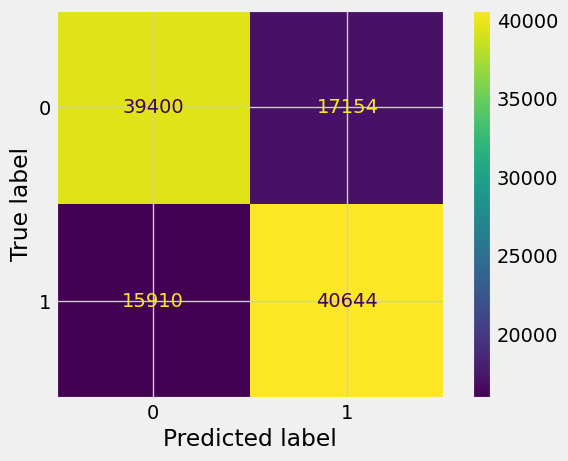

In [ ]:
#best_logregSMOTE = grid.best_estimator_
best_logregSMOTE = LogisticRegression(C=0.01, solver='newton-cg', penalty='l2', class_weight ='balanced')

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
best_logregSMOTE.fit(X_train_resampled, y_train_resampled)
execution_time_best_logregSMOTE = time.time() - start_time

# Make predictions on the testing data
best_logregSMOTE_pred = best_logregSMOTE.predict(X_test_resampled)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, best_logregSMOTE_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_logregSMOTE.classes_)
disp.plot()

# Print results
auroc_best_logregSMOTE = roc_auc_score(y_test_resampled, best_logregSMOTE_pred)
print('AUROC: ', auroc_best_logregSMOTE)
print()
print(classification_report(y_test_resampled, best_logregSMOTE_pred))
print('Temps éxecution: ', execution_time_best_logregSMOTE)

Les deux méthodes nous donnent des scores AUROC quasi-équivalent. Cependant, pour la méthode SMOTE, la précision est beaucoup plus élevée, précision : 70 %.
Ainsi, dans la suite de ce notebook, nous nous limiterons à l'utilisation d'algorithme avec la méthode SMOTE

## **SVM**

In [ ]:
# Define the parameter grid to search
param_grid = {
    'C': [0.0001, 0.001, 0.01],
    'class_weight': ['balanced']
}

# Create a svc model
svc = LinearSVC()
# Create the StratifiedKFold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Create the grid search object
grid = GridSearchCV(svc, param_grid, cv=cv, scoring='roc_auc')
# Fit the grid search to the data
grid.fit(X_train_resampled, y_train_resampled)

# print the best parameters
print('Meilleurs paramètres: ', grid.best_params_)
print('Meilleur estimateur: ', grid.best_estimator_)
print('Meilleurs scores (AUROC): ', grid.best_score_)

Meilleurs paramètres:  {'C': 0.01, 'class_weight': 'balanced'}
Meilleur estimateur:  LinearSVC(C=0.01, class_weight='balanced')
Meilleurs scores (AUROC):  0.7752794743141567


AUROC:  0.70780139335856

              precision    recall  f1-score   support

           0       0.71      0.70      0.70     56554
           1       0.70      0.72      0.71     56554

    accuracy                           0.71    113108
   macro avg       0.71      0.71      0.71    113108
weighted avg       0.71      0.71      0.71    113108

Temps éxecution:  8.484730243682861


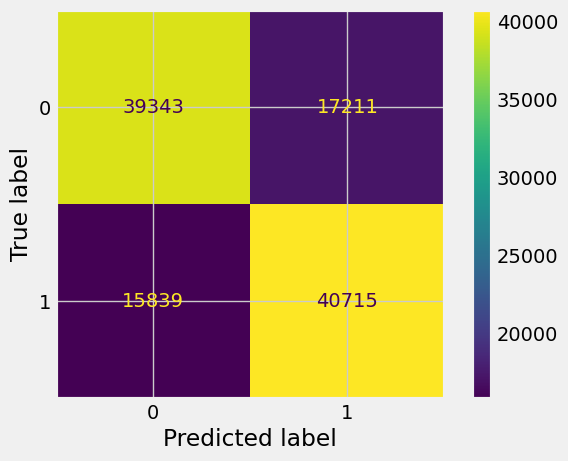

In [ ]:
#best_svc = grid.best_estimator_
best_svc = LinearSVC(C=0.01, class_weight ='balanced')

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
best_svc.fit(X_train_resampled, y_train_resampled)
execution_time_best_svc = time.time() - start_time

# Make predictions on the testing data
best_svc_pred = best_svc.predict(X_test_resampled)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, best_svc_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_svc.classes_)
disp.plot()

# Print results
auroc_best_svc = roc_auc_score(y_test_resampled, best_svc_pred)
print('AUROC: ', auroc_best_svc)
print()
print(classification_report(y_test_resampled, best_svc_pred))
print('Temps éxecution: ', execution_time_best_svc)

Notre SVC dispose d'un AUROC et d'une précision quasi-équivalente à la régréssion logistique. Cependant, la durée d'éxecution est beaucoup plus courte, 8.48 secondes.

## **Random Forest Classifier**

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators' : [75, 100],
    'max_depth' : [10],
    'min_samples_leaf' : [10],
    'class_weight': ['balanced']
}

# Create a classifier model
classifier = RandomForestClassifier()
# Create the StratifiedKFold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Create the grid search object
grid = GridSearchCV(classifier, param_grid, cv=cv, scoring='roc_auc')
# Fit the grid search to the data
grid.fit(X_train_resampled, y_train_resampled)

# print the best parameters
print('Meilleurs paramètres: ', grid.best_params_)
print('Meilleur estimateur: ', grid.best_estimator_)
print('Meilleurs scores (AUROC): ', grid.best_score_)

Meilleurs paramètres:  {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}
Meilleur estimateur:  RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=10)
Meilleurs scores (AUROC):  0.9486341265695388


AUROC:  0.8844202001626764

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56554
           1       0.90      0.86      0.88     56554

    accuracy                           0.88    113108
   macro avg       0.89      0.88      0.88    113108
weighted avg       0.89      0.88      0.88    113108

Temps éxecution:  121.76713395118713


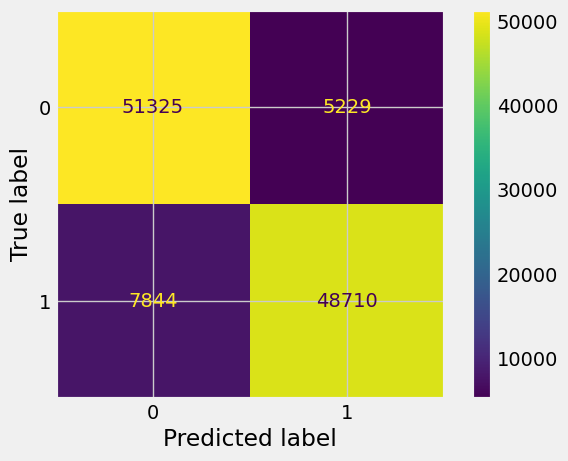

In [ ]:
#best_rfc = grid.best_estimator_
best_rfc = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10, class_weight ='balanced')

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
best_rfc.fit(X_train_resampled, y_train_resampled)
execution_time_best_rfc = time.time() - start_time

# Make predictions on the testing data
best_rfc_pred = best_rfc.predict(X_test_resampled)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, best_rfc_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_rfc.classes_)
disp.plot()

# Print results
auroc_best_rfc = roc_auc_score(y_test_resampled, best_rfc_pred)
print('AUROC: ', auroc_best_rfc)
print()
print(classification_report(y_test_resampled, best_rfc_pred))
print('Temps éxecution: ', execution_time_best_rfc)

La forêt aléatoire nous donne un auroc de 88.16 %
La précision est de 90 % pour la classe positive 
Ces mesures de performance sont largement meilleurs que les méthodes précédentes.
Le seul défault est un temps de calcul plus long. 

## **XGBoost**

AUROC:  0.9002015772535983

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     56554
           1       0.93      0.86      0.90     56554

    accuracy                           0.90    113108
   macro avg       0.90      0.90      0.90    113108
weighted avg       0.90      0.90      0.90    113108

Temps éxecution:  706.2578263282776


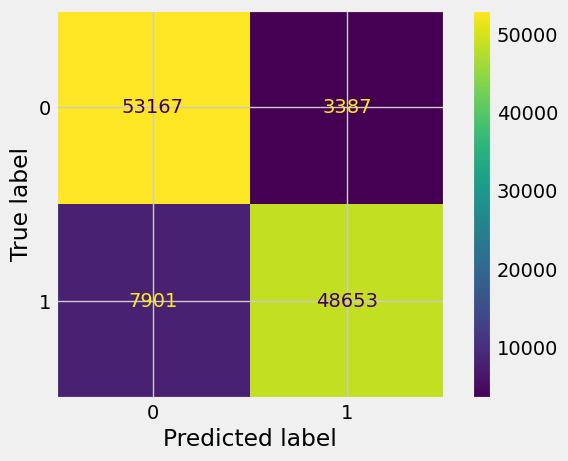

In [ ]:
from xgboost import XGBClassifier

params = {
    'objective':'binary:logistic',
    'max_depth': 5,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'n_estimators': 200 
}

# Define the XGBoost classifier with specified hyperparameters
xgbm = XGBClassifier(**params)

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
xgbm.fit(X_train_resampled, y_train_resampled)
execution_time_xgbm = time.time() - start_time

# Make predictions on the testing data
xgbm_pred = xgbm.predict(X_test_resampled)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, xgbm_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgbm.classes_)
disp.plot()

# Print results
auroc_xgbm = roc_auc_score(y_test_resampled, xgbm_pred)
print('AUROC: ', auroc_xgbm)
print()
print(classification_report(y_test_resampled, xgbm_pred))
print('Temps éxecution: ', execution_time_xgbm)

## **LightGBM**

In [ ]:
import lightgbm as lgb

# Define the parameter grid to search
param_grid = {
    'n_estimators' : [100, 200],
    'learning_rate' : [0.1],
    'subsample' : [0.50],
    'max_depth': [4, 5]
}

# Create a classifier model
lgbm = lgb.LGBMClassifier(random_state=1)
# Create the StratifiedKFold cross-validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
# Create the grid search object
grid = GridSearchCV(lgbm, param_grid, cv=cv, scoring='roc_auc')
# Fit the grid search to the data
grid.fit(X_train_resampled, y_train_resampled)

# print the best parameters
print('Meilleurs paramètres: ', grid.best_params_)
print('Meilleur estimateur: ', grid.best_estimator_)
print('Meilleurs scores (AUROC): ', grid.best_score_)

KeyboardInterrupt: ignored

AUROC:  0.9550429677830038

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       1.00      0.91      0.95     56554

    accuracy                           0.96    113108
   macro avg       0.96      0.96      0.95    113108
weighted avg       0.96      0.96      0.95    113108

Temps éxecution:  83.11251831054688


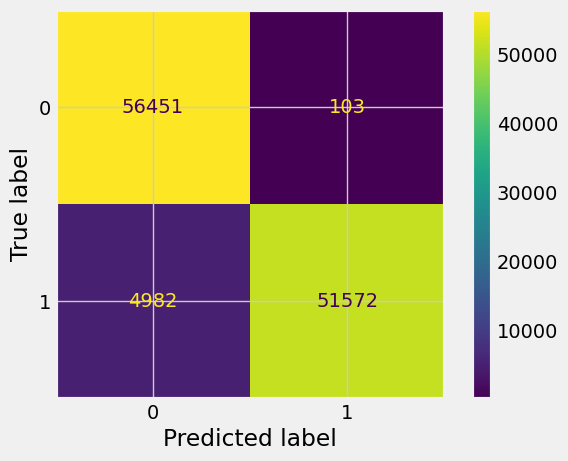

In [ ]:
#best_lgbm = grid.best_estimator_
best_lgbm = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=200, max_depth=5, subsample=0.50)

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
best_lgbm.fit(X_train_resampled, y_train_resampled)
execution_time_best_lgbm = time.time() - start_time

# Make predictions on the testing data
best_lgbm_pred = best_lgbm.predict(X_test_resampled)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, best_lgbm_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_lgbm.classes_)
disp.plot()

# Print results
auroc_best_lgbm = roc_auc_score(y_test_resampled, best_lgbm_pred)
print('AUROC: ', auroc_best_lgbm)
print()
print(classification_report(y_test_resampled, best_lgbm_pred))
print('Temps éxecution: ', execution_time_best_lgbm)

## **Application d'une fonction de coût au LightGBM**

Notre modèle LightGBM est actuellement le plus performant d'un point de vue technique. Nous allons encore l'améliorer en prenant en compte les besoins métiers.

Pour cela nous allons appliquer une fonction de coût métier de type 10*FN + FP et de trouver son minimum pour un seuil donné.

In [ ]:
from sklearn.metrics import make_scorer, fbeta_score

#Define custom function with 10 * FN + FP
#Définir la fonction de coût métier personnalisée
def cost_fn(y_true, y_pred):
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()

    cost = 10 * fn + fp

    return cost

# Définir le scorer pour la fonction de coût métier personnalisée
custom_scorer = make_scorer(cost_fn, greater_is_better=False)

# Set LightGBM parameters
params = {
    'learning_rate': [0.1],
    'max_depth': [4, 5],
    'n_estimators': [100, 200],
    'subsample': [0.5]
}

# Create LightGBM model
model = lgb.LGBMClassifier()

# Create RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=custom_scorer, cv=cv)
grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
print("best_model:", grid_search.best_estimator_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.5}
Best Score: -40356.1
best_model: LGBMClassifier(max_depth=5, n_estimators=200, subsample=0.5)


AUROC:  0.9550783322134596

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       1.00      0.91      0.95     56554

    accuracy                           0.96    113108
   macro avg       0.96      0.96      0.95    113108
weighted avg       0.96      0.96      0.95    113108

Temps éxecution:  49.027554512023926


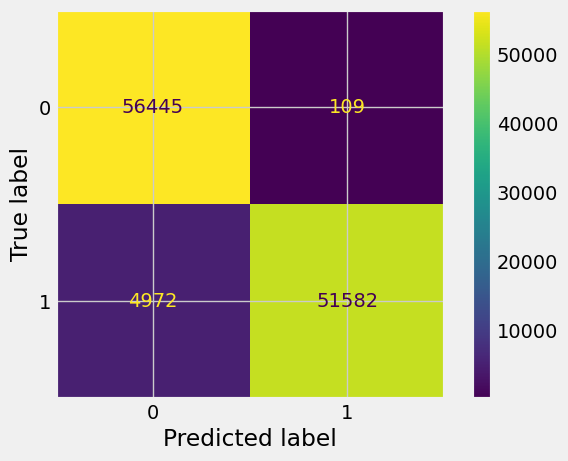

In [ ]:
#best_lgbm = grid.best_estimator_
best_lgbm = lgb.LGBMClassifier(**grid_search.best_params_)

start_time = time.time() # Calcul the exec time for training  
# Fit the model to the training data
best_lgbm.fit(X_train_resampled, y_train_resampled)
execution_time_best_lgbm = time.time() - start_time

# Make predictions on the testing data
best_lgbm_pred = best_lgbm.predict(X_test_resampled)
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_resampled, best_lgbm_pred)
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_lgbm.classes_)
disp.plot()

# Print results
auroc_best_lgbm = roc_auc_score(y_test_resampled, best_lgbm_pred)
print('AUROC: ', auroc_best_lgbm)
print()
print(classification_report(y_test_resampled, best_lgbm_pred))
print('Temps éxecution: ', execution_time_best_lgbm)

Prendre en compte les pertes relatives aux FP et FN nous retourne un coût de 40356

## **Feature Importance**

### **Interprétation globale**

Dans un premier temps nous allons voir le poids de chaque variable pour le modèle en générale.
Nous allons utiliser l'option feature_importances_

In [ ]:
# Print the feature importance
feature_importance = best_lgbm.feature_importances_
feature_names = app_train.columns

# Sort feature importance in descending order
sorted_indices = feature_importance.argsort()[::-1]
sorted_importance = feature_importance[sorted_indices]
sorted_names = feature_names[sorted_indices]

# Create a DataFrame for feature importance
df_feature_importance = pd.DataFrame({'Feature': sorted_names, 'Importance': sorted_importance})

# Print the DataFrame
print(df_feature_importance)

                             Feature  Importance
0                       EXT_SOURCE_3         550
1         AMT_REQ_CREDIT_BUREAU_YEAR         531
2           OBS_30_CNT_SOCIAL_CIRCLE         336
3                       EXT_SOURCE_2         321
4                ANNUITY_INCOME_PERC         208
..                               ...         ...
239                 FLAG_DOCUMENT_20           0
240                 FLAG_DOCUMENT_21           0
241        ORGANIZATION_TYPE_Telecom           0
242  ORGANIZATION_TYPE_Trade: type 5           0
243         NAME_INCOME_TYPE_Student           0

[244 rows x 2 columns]


In [ ]:
# Extraction of feature with importance = 0
zero_importance_features = df_feature_importance.loc[df_feature_importance['Importance'] == 0, 'Feature'].tolist()

# Print the features with importance equal to zero
print(zero_importance_features)
print()
print('Nous avons ', len(zero_importance_features), 'variables avec une importance nulle. Les supprimer permettra d économiser des ressources de calculs')

['WALLSMATERIAL_MODE_Mixed', 'FLAG_EMP_PHONE', 'HOUSETYPE_MODE_terraced house', 'FLAG_MOBIL', 'FONDKAPREMONT_MODE_not specified', 'ORGANIZATION_TYPE_XNA', 'HOUSETYPE_MODE_specific housing', 'ORGANIZATION_TYPE_Trade: type 6', 'ELEVATORS_MEDI', 'ORGANIZATION_TYPE_Transport: type 1', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents', 'OCCUPATION_TYPE_Realty agents', 'ORGANIZATION_TYPE_Bank', 'ORGANIZATION_TYPE_Culture', 'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Housing', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 12', 'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 8', 'ORGANIZATION_TYPE_Police', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Services', 'NAME_INCOME_TYPE_Businessman', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Group of people', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_D

### **Interprétation locale**

Nous avons 2 méthodes pour analyser l'importance des variables localement : LIME et SHAP

LIME n'est pas adapté pour fonctionner avec un jeu de données ou one hot encoder a été appliqué.

Ainsi pour notre interprétation locale, nous utiliserons la méthode SHAP

In [37]:
#! pip install shap
import shap

In [38]:
# Get the indices of the value 1 using list comprehension
indices_one = [i for i, val in enumerate(best_lgbm_pred) if val == 1]

# Fit the explainer
best_lgbm_explainer = shap.TreeExplainer(best_lgbm)

In [ ]:
# # Plot for the first positive value
# shap_values = best_lgbm_explainer.shap_values(np.reshape(X_test_resampled[indices_one[0], :], (1, -1)))

# shap.initjs()
# shap.summary_plot(shap_values, X_test_resampled, feature_names=app_train.columns, max_display=10)

In [39]:
# Plot for the first positive value
shap_values = best_lgbm_explainer.shap_values(np.reshape(X_test[indices_one[0], :], (1, -1)))

shap.initjs()
shap.force_plot(best_lgbm_explainer.expected_value[1], 
                shap_values[1],
                np.reshape(X_test[indices_one[0], :], (1, -1)),
                feature_names=app_test.columns)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [40]:
# # Plot for another positive value
# shap_values = best_lgbm_explainer.shap_values(np.reshape(X_test_resampled[indices_one[5], :], (1, -1)))

# shap.initjs()
# shap.summary_plot(shap_values, X_test_resampled, feature_names=app_train.columns, max_display=10)

In [41]:
# Plot for the second positive value
shap_values = best_lgbm_explainer.shap_values(np.reshape(X_test[indices_one[20], :], (1, -1)))

shap.initjs()
shap.force_plot(best_lgbm_explainer.expected_value[1], 
                shap_values[1],
                np.reshape(X_test[indices_one[20], :], (1, -1)),
                feature_names=app_test.columns)

L'interprétabilité de notre modèle change pour chasque individu. Cela permettra aux chargés de client de personaliser la réponse pour chaque client.
Si un client se voit refuser un prêt, on pourra lui dire concrètement quelles paramètres il doit changer pour améliorer son profil et donc obtenir un crédit. 